In [172]:
import pandas as pd
import numpy as np
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.ets import AutoETS

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
import numpy as np
import gradio as gr
from enum import Enum

from sktime.forecasting.compose import AutoEnsembleForecaster


class Sector(Enum):
    Region = "Region"
    Provincia = "Provincia"
    Comuna = "Comuna"

def load_data(path:str = "./data/trips.csv") -> pd.DataFrame:
    """load trips.csv data from path"""
    
    read_params = {
        "encoding": "latin_1",
        "sep": ";",
        "decimal": ","
        }

    return pd.read_csv(path, **read_params)

def to_date(month: int,year:int):
    return pd.Timestamp(day=1, month=month, year = year)

def to_date_row(x):
    month = x["month_value"]
    year = x["Anio"]
    return to_date(month, year)

def preprocess_data(data: pd.DataFrame, sector: Sector = Sector.Region) -> pd.DataFrame:
    """preprocess data, choose sector to get value"""
    
    data.columns = [x.strip() for x in data.columns]

    col_melt = list(data.columns[-12:]) #months as cols
    
    mn = "month_name"
    
    code_month = pd.DataFrame.from_dict(
        data={
            mn: col_melt,
            "month_value": list(range(1,13))})
    
    col_maintain = list(data.columns[:-12])
    
    data_long = data.melt(
        id_vars=col_maintain,
        value_vars=col_melt,
        var_name=mn).merge(
            code_month,
            how="left",
            on=mn)
    
    data_long["time_stamp"] = data_long.apply(
        to_date_row,axis = 1)
    
    # data_long["time_stamp"] = [to_date(year,month) for year,month  in zip(
    #     data_long["month_value"].values, data_long["Anio "].values)]
    
    unused_date_cols = ["Anio", "month_name", "month_value"]
    
    data_long.drop(columns= unused_date_cols, inplace=True)
    
    sector_name = sector.name
    cut_sector = ["CUT {} Origen", "CUT {} Destino"]
    
    col_sector = [x.format(sector_name) for x in cut_sector]
    kv = ["time_stamp", "value"]
    
    cols = col_sector.copy()
    
    for l in kv:
        cols.append(l)
    # cols = col_sector.extend(kv)
    
    
    data_sector = data_long[cols].copy()
    
    col_sector.append("time_stamp")
    data_agg = data_sector.groupby(by = col_sector).sum()
    data_agg.value = np.int32(data_agg.value.values)
    data_agg.query("value > 0", inplace = True)
    
    
    data_agg.reset_index(inplace=True)
    data_agg.set_index("time_stamp", inplace=True)
    data_agg = data_agg.to_period("M")
    
    
    
    renamer = {
    data_agg.columns[0]: "sector_origin",
    data_agg.columns[1]: "sector_destiny"
    }

    data_agg.rename(columns=renamer, inplace=True)
    data_agg.reset_index(inplace=True)
    
    # data_agg["sector_origin"] = data_agg["sector_origin"].astype("category")
    # data_agg["sector_destiny"] = data_agg["sector_destiny"].astype("category")
    
    data_agg.set_index(["sector_origin", "sector_destiny","time_stamp"],inplace=True)
    
    # data_agg = data_agg.reorder_levels([2,1,0])
    
    return data_agg


# from sktime.registry import all_estimators
# pd.set_option("display.max_rows", 100)

# hier_forecasters = all_estimators(
#     "forecaster", as_dataframe=True, return_tags=["scitype:y", "y_inner_mtype"]
# )

# hier_forecasters = hier_forecasters[(hier_forecasters["y_inner_mtype"] != "pd.Series") & 
#                                     (hier_forecasters["y_inner_mtype"] != "pd.DataFrame")]
# hier_forecasters


def predict_dataframe(data_agg: pd.DataFrame, h:int = 12, prd:int = 24) -> ThetaForecaster:
    """predict dataframe

    Args:
        data_grouped (pd.DataFrame): grouped dataframe with values
        h (int, optional): Window to forecast, in months

    Returns:
        pd.Series: _description_
    """
    
    data_flat = data_agg.reset_index().copy()
    periods = data_flat["time_stamp"].unique()
    last_2years = periods[-prd:]
    data_flat = data_flat[data_flat["time_stamp"].isin(last_2years)]
    data_flat.set_index(["sector_origin", "sector_destiny", "time_stamp"], inplace=True)
    
    
    # forecasters = [
    # # ("TBATS", TBATS(sp = 12)),
    # ("Theta", ThetaForecaster(sp= 12)),
    # ("ETS", AutoETS(sp = 12))
    # ]
    
    
    # forecaster = AutoEnsembleForecaster(   
    #     forecasters=forecasters, test_size= 0.15)
    
    forecaster = ThetaForecaster(sp=12)
    
    fh = ForecastingHorizon(np.arange(1,h), is_relative= True)
    
    forecaster = forecaster.fit(y = data_flat, fh=fh)
    return forecaster
    

def create_plot(
    data_agg: pd.DataFrame,
    pred: pd.DataFrame,
    pred_inter: pd.DataFrame,
    is_multicol: bool,
    sector_origin: int | None = 1,
    sector_destiny: int | None = 1):
    
    def to_series(data: pd.DataFrame, sector_origin:int, sector_destiny:int, is_multi = False) -> pd.DataFrame:
        df = data.reset_index().copy()
        qry  = "sector_origin == {} & sector_destiny == {}".format(sector_origin, sector_destiny)
        
        if not is_multi:
            df.query(qry, inplace=True)
        else:
            df = df[(df.iloc[:, 0] == sector_origin) & (df.iloc[:, 1] == sector_destiny)]
        
        drop_cols = ["sector_origin", "sector_destiny"]
        
        if is_multi:
            drop_cols = [(x, "", "") for x in drop_cols]
        
        return df.drop(columns=drop_cols).set_index("time_stamp").squeeze()
    x = to_series(data_agg, sector_origin, sector_destiny)
    y = to_series(pred, sector_origin, sector_destiny)
    p_int= to_series(pred_inter, sector_origin, sector_destiny, True)

    # x_df = data_agg.reset_index().copy()
    # y_df = pred.reset_index().copy()
    # p_df = pred_inter.reset_index().copy()
    # qry = "sector_origin == {} & sector_destiny == {}".format(sector_origin, sector_destiny)
    
    # x_df.query(qry,inplace=True)
    # y_df.query(qry, inplace=True)
    # p_df.query(qry, inplace = True)
    
    # x = x_df.drop(columns=["sector_origin", "sector_destiny"]).set_index("time_stamp").squeeze()
    # y = y_df.drop(columns=["sector_origin", "sector_destiny"]).set_index("time_stamp").squeeze()
    
    title = "Monthly touristic travels from region {} to region {}".format(sector_origin, sector_destiny)
    return  plot_series(x,y,labels=["value", "forecast"],title=title)



In [127]:
data = load_data()
data_preprocessed = preprocess_data(data)

c:\Users\MSI\Documents\python\time_series\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\MSI\Documents\python\time_series\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\MSI\Documents\python\time_series\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\MSI\Documents\python\time_series\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\MSI\Documents\python\time_series\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\MSI\Do

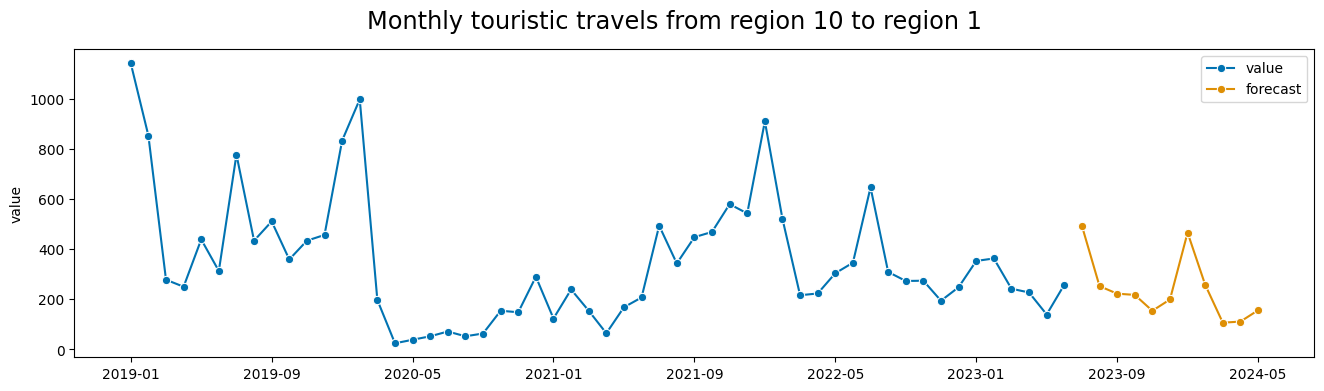

In [173]:
forecaster = predict_dataframe(data_preprocessed)
pred = forecaster.predict()
pred_inter = forecaster.predict_interval()
plt_s = create_plot(data_preprocessed, pred, pred_inter, 13, 10)

In [175]:
np.arange(1,17).tolist()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [166]:
df_inter = pred_inter.reset_index().copy()


sector_origin sector_destiny time_stamp             0              
                                                     0.9              
                                                   lower         upper
0              1              1    2023-07  12493.416492  18548.502864
1              1              1    2023-08  11552.734280  17941.179251
2              1              1    2023-09  11706.888525  18412.139253
3              1              1    2023-10   9862.646945  16870.395906
4              1              1    2023-11   5250.204869  12547.923942
5              1              1    2023-12   8648.646008  16225.245630
6              1              1    2024-01  11452.026197  19297.599471
7              1              1    2024-02  11036.365506  19141.991834
8              1              1    2024-03   6790.620223  15148.211763
9              1              1    2024-04   9653.901528  18256.081166
10             1              1    2024-05   6784.623264  15624.626244